this makes plots which contain the distance from the center of the tumor on the x-axis

In [1]:
import random
%pylab inline
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid.inset_locator import inset_axes
sns.set_style('white')
sns.set_context('paper', font_scale=1.5)
from glob import glob
YELLOW = sns.xkcd_rgb["amber"]
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
CTC_SIZES = [(2,7), (8,12), (13,17), (18,22),(23,30)]

ALTERNATE_COLORS = sns.xkcd_palette(["vomit green", "orangish brown", "azure", "dark pink"])
small_c, med_c, big_c, biggest_c = ALTERNATE_COLORS

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# load data from HCC tumor

HCC = pd.read_csv('../clinical_data/HCCtumordata.csv')
HCC = HCC.sort(columns='r')

/Users/Zaf/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [4]:
import random
import json
import statsmodels.api as sm

In [5]:
# creates a color map that you can use like this: create_colormap(y) --> rgba color value
def create_colormap(colormap_name='cubehelix_r', with_yellow=False,n_colors=8, use_range=(1,3,4,6,7,7), start_bin=2, each_bin=5, return_colormap=False):
    colors = sns.color_palette(colormap_name, n_colors=n_colors)
    bin_ = start_bin
    color_mapping = {}
    for color in use_range: #map through all colors
        for i in xrange(each_bin):
            color_mapping[bin_+i] = colors[color]
        bin_= bin_ + each_bin
    
    if return_colormap:
        col_list = [ colors[i] for i in use_range]
        if with_yellow:
            col_list = [ YELLOW ] + col_list
#             col_list = [ YELLOW ] + col_list + ALTERNATE_COLORS
        return mpl.colors.ListedColormap( col_list )
    def c_mapper(i):
        print i
        try:
            if i == 1 and with_yellow:
                return YELLOW
            elif i == 100:
                return small_c
            elif i == 1000:
                return med_c
            elif i == 10000:
                return big_c
            elif i == 20000:
                return biggest_c
            else:
                return color_mapping[i]
        except Exception as e:
            print('error')
            return color_mapping[sorted(color_mapping.keys())[-1]]
    return c_mapper

In [6]:
def exponential_mean_function(x_i, y_i,k=1):
    """
        @params:
            x_i : all x_i points available
            y_i : the y_i values to average over
        @returns
            a function that can be evaluated for the mean at any point x
        
    """
    def exponential_mean_at(x):
        """
            @params:
                x: a np.array or float where the average value needs to be returned
            @returns
                <y(x)> : average value at position x
        """
        w = exp(-k*(x-x_i)**2)
        return np.dot(w, y_i) / np.sum(w)
    
    return exponential_mean_at


In [7]:
def prepare_data2(folder, yaxis='S_list_ordered', k=0.01, pts=100):
    """
        Load data from .npy files
    """
    
    
    assert yaxis in ['S_list01_big', 'S_list001_big', 'S_list00_big', 'S_list_simulated','S_list_ordered', 'D_list_ordered', 'cdrv_list_ordered', 'csnp_list_ordered'], 'yaxis is not recognized for prepare_data2'
    
    ISBIG = yaxis in ['S_list01_big', 'S_list001_big', 'S_list00_big']
    dist_file = 'dist_'+yaxis.split('_list')[1] if ISBIG else 'deltas_ordered'
    if len(glob(folder+'Dec2*/'+dist_file+'.npy')) == 0:
        raise Exception('No files found in '+folder)

    distances = np.load(glob(folder+'Dec*/'+dist_file+'.npy')[0])

    if not ISBIG:
        distances = distances[:, 0]
        
    S = np.load(glob(folder+'Dec*/'+yaxis+'.npy')[0])
    prepped = {}
    all_sizes = [1,2,3,4] if yaxis in ['S_list01_big', 'S_list001_big', 'S_list00_big'] else list([1] + CTC_SIZES)
    for ctc_size in all_sizes:
        slice_range = None
        x = None
        y = None
        color = None
        if type(ctc_size) is int: # check if this is an int so that we can handle different compared to a range...
            x = distances
            y = S[:, ctc_size-1]
            if ISBIG:
                y = y[:100]
                x = distances[:100, ctc_size-1]
            ctc_size = (ctc_size,)
        else:
            slice_range = range(ctc_size[0]-1, ctc_size[1])
            x = np.repeat(distances, ctc_size[1]-ctc_size[0]+1)
            y = S[:,slice_range].reshape(1,-1)[0]
        
        minp = 0
        maxp = distances.max() #define the maximum tumor size
        x_av = np.linspace(minp, maxp, pts)
        moving_avg_function = np.vectorize(exponential_mean_function(x,y, k = k)) # returns a function
        y_av = moving_avg_function(x_av)
        
        if ISBIG:
#             print 'idx=',ctc_size[0]
            _ctc_size = 10**(ctc_size[0]+1) if ctc_size[0] != 4 else 2*10**4
#             print 'powered=',_ctc_size
            ctc_size = (_ctc_size, ) 
        prepped[ctc_size] = [x_av, y_av]
        
    return prepped

In [8]:
def cross_sim_average(samples):
    to_be_returned = {}
    ctc_sizes = samples[0].keys()
    for ctc_size in ctc_sizes:
        to_be_avged_x = []
        to_be_avged_y = []
        # go through all samples and extract that 
        for sample in samples:
            to_be_avged_x.append(sample[ctc_size][0])
            to_be_avged_y.append(sample[ctc_size][1])

        to_be_avged_x = np.array(to_be_avged_x)
        to_be_avged_y = np.array(to_be_avged_y)
        
        x_avgd = np.mean(to_be_avged_x, axis=0)
        y_avgd = np.mean(to_be_avged_y, axis=0)
        to_be_returned[ctc_size] = [x_avgd, y_avgd]
        
    return to_be_returned
        
        

In [15]:
def data_to_plot(folder, seeds, yaxis='unique_combos', k=0.01, pts=100, mode=1, d='005'):
    samples = [] # all samples will be held here
    # first prep the data for each seed
#     print 'DATA_TO_PLOT - FOLDER:'+folder+' SEEDS:'+str(seeds)+' d:'+d

    for seed in seeds:
        this_folder = folder+'_'+d+'_outs_'+seed+'/'
#         print this_folder
        try:
            if mode == 1:
                samples.append(prepare_data1(this_folder, yaxis=yaxis, k=k, pts=pts))
            else:
                samples.append(prepare_data2(this_folder, yaxis=yaxis, k=k, pts=pts))
        except Exception as e:
            print 'data_to_plot Exception:'+str(e)
            print 'Skipped Folder:'+this_folder
#             raise e
    # produce the cross sample average
    cross_sample_averaged = cross_sim_average(samples)
    return cross_sample_averaged, samples


In [9]:
def plot_it(cross_sample_averaged, ax):
    colors = create_colormap(with_yellow=True)
    for ctc_size in cross_sample_averaged.keys():
        x,y = cross_sample_averaged[ctc_size]
        ax.plot(x,y, color=colors(ctc_size[0]))
        
        if ctc_size[0] == 1:
            print 'mean(s(1))',np.mean(y)
            print 'std(s(1))', np.std(y)
            print 's(1)_core',np.mean(y[:10])
            print 's(1)_edge',np.mean(y[10:])

In [10]:
def plot_density(ax, folder, seeds, d='005'):
    r_samples = [] # all samples will be held here
    rho_samples = [] # all samples will be held here
    # first prep the data for each seed
#     print 'PLOT DENSITY folder:'+folder+' seeds:'+str(seeds)+' d='+d
    for seed in seeds:
        this_folder = folder+'_'+d+'_outs_'+seed+'/'
#         print this_folder
        try:
            r_samples.append(np.load(glob(this_folder+'/Dec*/r_meaned.npy')[0]))
            rho_samples.append(np.load(glob(this_folder+'/Dec*/rho2.npy')[0]))
        except Exception as e:
            print 'Exception: '+str(e)
            print 'Skipped Folder: '+this_folder
    print len(r_samples)
    print len(rho_samples)
    r = np.mean(np.array(r_samples), axis=0)
    rho = np.mean(np.array(rho_samples), axis=0)

    ax1_r = ax.twinx()
    ax1_r.fill_between(r, rho,alpha=0.09,color=(0,0,0))
    ax1_r.set_ylim([0,1.1])
    ax1_r.set_ylabel('Tumor Cell Density', rotation=-90,labelpad=15)


In [11]:
def create_colorbar(subaxes, with_yellow=False):
    cb = mpl.colorbar.ColorbarBase(subaxes, cmap=create_colormap(return_colormap=True, with_yellow=with_yellow),
    #                                 tick=['2-7', '8-13', '14-19', '20-25', '26-30'],
    #                                 extend='both',
                                    # Make the length of each extension
                                    # the same as the length of the
                                    # interior colors:
    #                                 extendfrac='auto',
    #                                 ticks=bounds,
                                    spacing='uniform',
                                    orientation='horizontal')
    cb.set_label('Cluster Sizes')
    cb.ax.get_xaxis().labelpad = 0

    ticklocs = [0.03, 0.2, 0.33, 0.5, 0.65,0.85] # location of ticks
    ticklabels = ['1', '2-7', '8-12', '13-17', '18-22', '23-30', '10^2', '10^3', '10^4', '2*10^4'] # tick labels

#     ticklocs = [0.03, 0.1, 0.21, 0.33, 0.4, 0.5, 0.65, 0.75, 0.85, 0.9] # location of ticks
#     ticklabels = ['1', '2-7', '8-12', '13-17', '18-22', '23-30', '10^2', '10^3', '10^4', '2*10^4'] # tick labels

    if not with_yellow:
        ticklabels = ticklabels[1:]
        ticklocs = list(np.linspace(0.05,0.6,4))+[0.8]

    cb.set_ticks(ticklocs)
    cb.ax.set_xticklabels(ticklabels, fontsize = 9, rotation=30)




In [12]:
def S_plot(root_folder, seeds, k=0.01, pts=100, d='005'):

    fig = plt.figure(figsize=(11,3))

    ax = fig.add_subplot(131)
    folder = root_folder+'/1_0'
    d2='0'

    plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d2), ax)
#     plot_density(ax, folder, seeds, d=d2)
    
    ax.set_title('(a) No Turnover')
    ax.set_xlim([50,325])
#     ax.set_ylim([0,])
    ax.set_ylabel('Mean # Somatic Mutations')
    ax.set_xlabel('Distance from Centre of Tumor (cells)')

    cmap_ax = ax # for later use
    
    ax = fig.add_subplot(132)
    folder = root_folder+'/1_1'
    
    plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d), ax)
#     plot_density(ax, folder, seeds, d=d)
    
    ax.set_title('(b) Surface Turnover')
    ax.set_xlim([50,325])
    ax.set_ylabel('Mean # Somatic Mutations')
    ax.set_xlabel('Distance from Centre of Tumor (cells)')
#     ax.set_ylim([0,1])

    ax = fig.add_subplot(133)
    folder = root_folder+'/1_0'
    
    plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d), ax)
#     plot_density(ax, folder, seeds, d=d)
    
    ax.set_title('(c) Turnover')
    ax.set_ylabel('Mean # Somatic Mutations')
    x_max = 350 if d=='02' else 325 
    x_max = 750 if d=='065' else x_max 
    ax.set_xlim([50,x_max])
    ax.set_xlabel('Distance from Centre of Tumor (cells)')
#     ax.set_ylim([0,50])

    fig.tight_layout(pad=1, w_pad=0.5)
    
    
    subaxes = inset_axes(cmap_ax,
                        width="90%", # width = 30% of parent_bbox
                        height=0.15, # height : 1 inch
                        loc=2)
    
    create_colorbar(subaxes,with_yellow=True)
    fig.suptitle('d=0.'+d[1:],x =0.5, y=1)
    return fig


# figure 2

In [67]:
sns.set_context('paper', font_scale=1.5)

In [39]:
q, z = data_to_plot('/Volumes/Stockage/u0.03simulations/1_0',
             ['101','1','2','0','3','4','5','102','12151', '12152'],
            yaxis='S_list_ordered', mode=2, d='0')

In [26]:
colors = create_colormap(with_yellow=True)

1


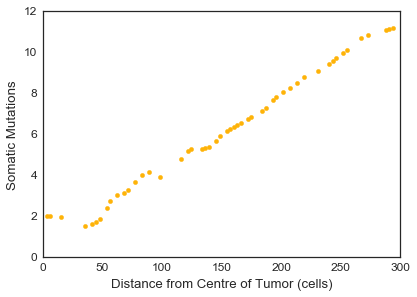

In [73]:
plt.xlabel('Distance from Centre of Tumor (cells)')
plt.ylabel('Somatic Mutations')
plt.scatter(*zip(*random.sample(zip(*z[0][(1,)]), 50)), color=colors(1), marker='o')
# plt.scatter(*z[1][(1,)], color=colors(1), marker='o')
# plt.scatter(*z[2][(1,)], color=colors(1), marker='o')
plt.xlim((0, 300))
plt.ylim((0, 12))
plt.savefig('one.pdf')
plt.savefig('one.png',dpi=500)

1
1


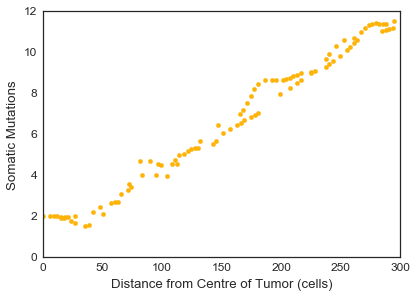

In [72]:
plt.xlabel('Distance from Centre of Tumor (cells)')
plt.ylabel('Somatic Mutations')
plt.scatter(*zip(*random.sample(zip(*z[0][(1,)]), 50)), color=colors(1), marker='o')
plt.scatter(*zip(*random.sample(zip(*z[1][(1,)]), 50)), color=colors(1), marker='o')
plt.scatter(*z[2][(1,)], color=colors(1), marker='o')
plt.xlim((0, 300))
plt.ylim((0, 12))
plt.savefig('two.pdf')
plt.savefig('two.png',dpi=500)

1
1
1
1
1
1
1
1
1
1


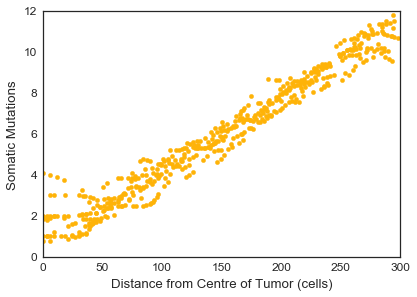

In [74]:
plt.xlabel('Distance from Centre of Tumor (cells)')
plt.ylabel('Somatic Mutations')
for z_ in z:
    plt.scatter(*zip(*random.sample(zip(*z_[(1,)]), 50)), color=colors(1), marker='o')
plt.xlim((0, 300))
plt.ylim((0, 12))
plt.savefig('tot.pdf')
plt.savefig('tot.png',dpi=500)

1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2


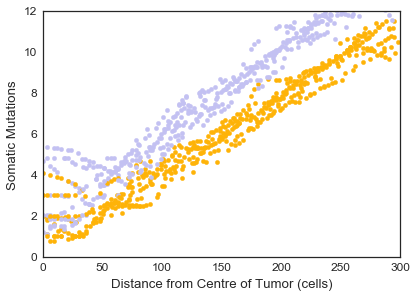

In [75]:
plt.xlabel('Distance from Centre of Tumor (cells)')
plt.ylabel('Somatic Mutations')
for z_ in z:
    plt.scatter(*zip(*random.sample(zip(*z_[(1,)]), 50)), color=colors(1), marker='o')
    plt.scatter(*zip(*random.sample(zip(*z_[(2,7)]), 50)), color=colors(2), marker='o')
plt.xlim((0, 300))
plt.ylim((0, 12))
plt.savefig('tot2.pdf')
plt.savefig('tot2.png',dpi=500)

2
23
18
1
8
13
2
23
18
1
8
13
2
23
18
1
8
13
2
23
18
1
8
13
2
23
18
1
8
13
2
23
18
1
8
13
2
23
18
1
8
13
2
23
18
1
8
13
2
23
18
1
8
13
2
23
18
1
8
13


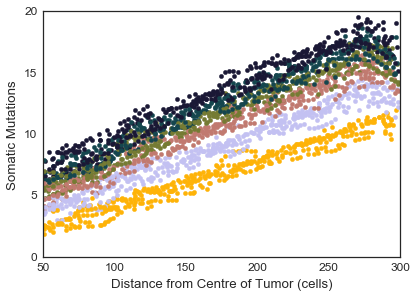

In [79]:
plt.xlabel('Distance from Centre of Tumor (cells)')
plt.ylabel('Somatic Mutations')
for z_ in z:
    for ctc_range in z_.keys():
        plt.scatter(*zip(*random.sample(zip(*z_[ctc_range]), 50)), color=colors(ctc_range[0]), marker='o')
plt.xlim((50, 300))
plt.ylim((0, 20))
plt.savefig('tot3.pdf')
plt.savefig('tot3.png',dpi=500)

2
23
18
1
8
13


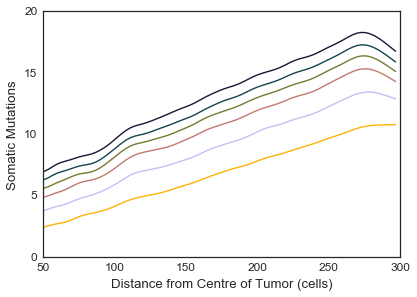

In [84]:
plt.xlabel('Distance from Centre of Tumor (cells)')
plt.ylabel('Somatic Mutations')
for ctc_range in q.keys():
    plt.plot(*q[ctc_range], color=colors(ctc_range[0]))
plt.xlim((50, 300))
plt.ylim((0, 20))
plt.savefig('avg.pdf')
plt.savefig('avg.png',dpi=500)

In [88]:
for d in ['0', '005' ,'01', '02']:
    q, z = data_to_plot('/Volumes/Stockage/u0.03simulations/1_0',
                 ['101','1','2','0','3','4','5','102','12151', '12152'],
                yaxis='S_list_ordered', mode=2, d=d)
    plt.xlabel('Distance from Centre of Tumor (cells)')
    plt.ylabel('Somatic Mutations')
    for ctc_range in q.keys():
        plt.plot(*q[ctc_range], color=colors(ctc_range[0]))
    plt.xlim(xmin=50)
    plt.ylim(ymin=0)
    plt.savefig('avg_'+d+'.pdf')
    plt.savefig('avg_'+d+'.png',dpi=500)
    plt.clf()

2
23
18
1
8
13
2
23
18
1
8
13
2
23
18
1
8
13
2
23
18
1
8
13


In [102]:
lines

In [103]:
labels

[(2, 7), (23, 30), (18, 22), (1,), (8, 12), (13, 17)]

In [111]:
from __future__ import print_function

[((1,), <matplotlib.lines.Line2D at 0x11edb7950>),
 ((2, 7), <matplotlib.lines.Line2D at 0x11eda5a90>),
 ((8, 12), <matplotlib.lines.Line2D at 0x11edb7f90>),
 ((13, 17), <matplotlib.lines.Line2D at 0x11fc01610>),
 ((18, 22), <matplotlib.lines.Line2D at 0x11edb7310>),
 ((23, 30), <matplotlib.lines.Line2D at 0x11ed5a6d0>)]

[((1,), (2, 7), (8, 12), (13, 17), (18, 22), (23, 30)),
 (<matplotlib.lines.Line2D at 0x11edb7950>,
  <matplotlib.lines.Line2D at 0x11ed5a6d0>)]

[((1,), (2, 7), (8, 12), (13, 17), (18, 22), (23, 30)),
 (<matplotlib.lines.Line2D at 0x11edb7950>,
  <matplotlib.lines.Line2D at 0x11ed5a6d0>)]

2
23
18
1
8
13


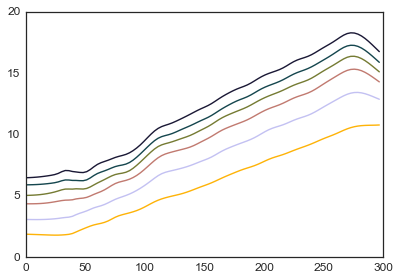

In [126]:
import pylab

fig = pylab.figure()
figlegend = pylab.figure(figsize=(3,2))
ax = fig.add_subplot(111)
lines = []
labels = []

d='0'
q, z = data_to_plot('/Volumes/Stockage/u0.03simulations/1_0',
                    ['101','1','2','0','3','4','5','102','12151', '12152'],
                    yaxis='S_list_ordered', mode=2, d=d)
for ctc_range in q.keys():
    lines += ax.plot(*q[ctc_range], color=colors(ctc_range[0]), label='size='+str(ctc_range))
    labels += [ctc_range]
    
labels, lines = zip(*reversed(sorted(zip(labels, lines), key=lambda t: t[0][0])))
figlegend.legend(lines, labels, 'center')
figlegend.show()
figlegend.savefig('legend.pdf')


In [16]:
def S_plot_paper(root_folder, seeds, k=0.01, pts=100, cutoff='00'):

    fig = plt.figure(figsize=(13,3))

    ax = fig.add_subplot(141)
    folder = root_folder+'/1_0'
    d2='0'

    plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d2), ax)
#     plot_it(data_to_plot(folder, seeds, yaxis='S_list'+cutoff+'_big', mode=2, d=d2), ax)
    plot_density(ax, folder, seeds, d=d2)


    
    ax.set_title('(a) No Turnover')
    ax.set_xlim([50,325])
    ax.set_ylim([0,30])
    ax.set_ylabel('Mean S(n)')
    ax.set_xlabel('Distance from Centre \n of Tumor (cells)')

    cmap_ax = ax # for later use
    
    d = '005'
    ax = fig.add_subplot(142)
    folder = root_folder+'/1_0'
    
    plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d), ax)
#     plot_it(data_to_plot(folder, seeds, yaxis='S_list'+cutoff+'_big', mode=2, d=d), ax)
    plot_density(ax, folder, seeds, d=d)
    
    ax.set_title('(b) Turnover, d=0.'+d[1:])
    ax.set_xlim([50,325])
    ax.set_ylabel('Mean S(n)')
    ax.set_xlabel('Distance from Centre \n of Tumor (cells)')
#     ax.set_ylim([0,1])


    d = '01'
    ax = fig.add_subplot(143)
    folder = root_folder+'/1_0'
    plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d), ax)
#     plot_it(data_to_plot(folder, seeds, yaxis='S_list'+cutoff+'_big', mode=2, d=d), ax)
    plot_density(ax, folder, seeds, d=d)
    
    ax.set_title('(c) Turnover, d=0.'+d[1:])
    ax.set_ylabel('Mean S(n)')
    x_max = 350 if d=='02' else 325 
    x_max = 750 if d=='065' else x_max 
    ax.set_xlim([50,x_max])
    ax.set_xlabel('Distance from Centre \n of Tumor (cells)')
    
    
    d = '02'
    ax = fig.add_subplot(144)
    folder = root_folder+'/1_0'
    
    plot_it(data_to_plot(folder, seeds, yaxis='S_list_ordered', mode=2, d=d), ax)
#     plot_it(data_to_plot(folder, seeds, yaxis='S_list'+cutoff+'_big', mode=2, d=d), ax)
    plot_density(ax, folder, seeds, d=d)
    
    ax.set_title('(d) Turnover, d=0.'+d[1:])
    ax.set_ylabel('Mean S(n)')
    x_max = 350 if d=='02' else 325 
    x_max = 750 if d=='065' else x_max 
    ax.set_xlim([50,x_max])
    ax.set_xlabel('Distance from Centre \n of Tumor (cells)')
#     ax.set_ylim([0,50])

    fig.tight_layout(pad=1, w_pad=0.5)
    
    
    subaxes = inset_axes(cmap_ax,
                        width="90%", # width = 30% of parent_bbox
                        height=0.15, # height : 1 inch
                        loc=2)
    
    create_colorbar(subaxes,with_yellow=True)
    return fig



2
23
18
1
mean(s(1)) 5.97498691633
std(s(1)) 3.0051948453
s(1)_core 1.83038382509
s(1)_edge 6.43549837091
8
13
10
10
2
23
18
1
mean(s(1)) 6.43942833396
std(s(1)) 2.95565829879
s(1)_core 2.27973513008
s(1)_edge 6.90161646772
8
13
10
10
2
23
18
1
mean(s(1)) 6.83907951405
std(s(1)) 2.92470641148
s(1)_core 2.43708351569
s(1)_edge 7.32819018054
8
13
10
10
2
23
18
1
mean(s(1)) 8.32013690364
std(s(1)) 2.68371136973
s(1)_core 3.99999911516
s(1)_edge 8.80015221347
8
13
10
10


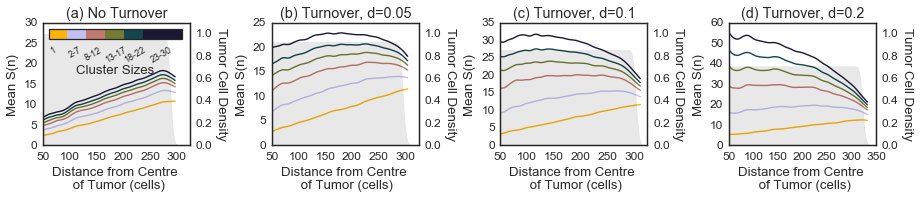

In [17]:
S_plot_paper('/Volumes/Stockage/u0.03simulations/',['101','1','2','0','3','4','5','102','12151', '12152'], cutoff='00').savefig('fig02.pdf')